In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
import xarray
from tqdm import tqdm

from compstat_research.config import INTERIM_DATA_DIR, MPLSTYLE_DIR, PROCESSED_DATA_DIR

plt.style.use(MPLSTYLE_DIR / "iragca_cmr10.mplstyle")

2025-03-02 13:23:34.624 | INFO     | compstat_research.config:<module>:11 - PROJ_ROOT path is: D:\Documents\3 Production Save Files\1 Cloned repositories\compstat-research


In [2]:
DATA_PATH = INTERIM_DATA_DIR / "cds" / "era5" / "multivars-ph"
SAVE_PATH = PROCESSED_DATA_DIR / "cds" / "era5" / "multivars-ph"

if not SAVE_PATH.exists():
    SAVE_PATH.mkdir(parents=True)

In [4]:
file_names = [
    "2m_dewpoint_temperature_stream-oper_daily-mean",
    "2m_temperature_0_daily-mean",
    "sea_surface_temperature_0_daily-mean",
    "surface_net_solar_radiation_0_daily-mean",
    "total_cloud_cover_0_daily-mean",
    "total_precipitation_0_daily-mean",
]

for file_name in tqdm(file_names):

    save_df = pl.DataFrame()

    for folder in tqdm(DATA_PATH.iterdir()):
        if folder.suffix == "":
            for file in (DATA_PATH / folder.name).iterdir():
                if file.name == f"{file_name}.nc":
                    ds = pl.DataFrame(
                        xarray
                        .open_dataset(file)
                        .to_dataframe()
                        .drop(["number"], axis=1)
                        .reset_index()
                    )
                    save_df = pl.concat([save_df, ds])

    save_df.write_parquet(SAVE_PATH / f"{file_name}.parquet")

2040it [00:30, 66.74it/s]00<?, ?it/s]
2040it [00:27, 74.92it/s]36<03:04, 36.82s/it]
2040it [00:27, 74.14it/s]09<02:17, 34.45s/it]
2040it [00:26, 75.91it/s]42<01:40, 33.67s/it]
2040it [00:27, 73.61it/s]14<01:06, 33.25s/it]
2040it [00:27, 74.13it/s]48<00:33, 33.22s/it]
100%|██████████| 6/6 [03:20<00:00, 33.49s/it]


In [ ]:
# Extract the month from the 'valid_time' column
save_df = save_df.with_columns([
    pl.col("valid_time").dt.month().alias("month"),
    pl.col("valid_time").dt.year().alias("year")
    ])

In [27]:
# Group by the extracted month
grouped_df = save_df.group_by(["year", "month"]).agg(
    pl.col("d2m").mean()
)

<Axes: xlabel='year', ylabel='d2m'>

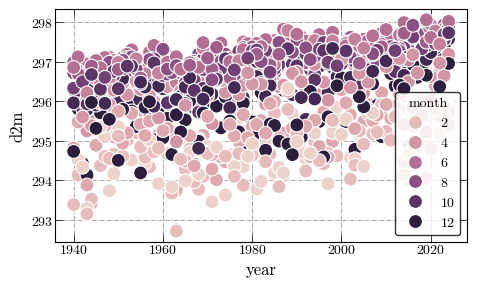

In [29]:
sns.scatterplot(data=grouped_df.to_pandas(), x="year", y="d2m", hue="month")

In [20]:
save_df

valid_time,latitude,longitude,d2m,month,year
datetime[ns],f64,f64,f32,i8,i32
1940-02-01 00:00:00,20.0,120.0,293.77832,2,1940
1940-02-01 00:00:00,20.0,120.25,293.756348,2,1940
1940-02-01 00:00:00,20.0,120.5,293.827637,2,1940
1940-02-01 00:00:00,20.0,120.75,293.881836,2,1940
1940-02-01 00:00:00,20.0,121.0,293.818848,2,1940
…,…,…,…,…,…
2024-12-31 00:00:00,5.0,129.0,296.738159,12,2024
2024-12-31 00:00:00,5.0,129.25,296.635132,12,2024
2024-12-31 00:00:00,5.0,129.5,296.516479,12,2024


In [6]:
save_df.write_parquet(SAVE_PATH / "total_cloud_cover.parquet")

In [4]:
TCC_TABLE = """
CREATE OR REPLACE TABLE total_cloud_cover (
    valid_time TIMESTAMP,
    latitude FLOAT,
    longitude FLOAT,
    tcc FLOAT
  );
"""
DB.sql(TCC_TABLE)

In [5]:
DB.sql("INSERT INTO total_cloud_cover SELECT * FROM save_df")

In [7]:
DB.sql("SELECT * FROM total_cloud_cover LIMIT 10")

┌─────────────────────┬──────────┬───────────┬────────────┐
│     valid_time      │ latitude │ longitude │    tcc     │
│      timestamp      │  float   │   float   │   float    │
├─────────────────────┼──────────┼───────────┼────────────┤
│ 1940-02-01 00:00:00 │     20.0 │     120.0 │ 0.43666077 │
│ 1940-02-01 00:00:00 │     20.0 │    120.25 │ 0.46969604 │
│ 1940-02-01 00:00:00 │     20.0 │     120.5 │ 0.47080994 │
│ 1940-02-01 00:00:00 │     20.0 │    120.75 │ 0.46748352 │
│ 1940-02-01 00:00:00 │     20.0 │     121.0 │ 0.46804047 │
│ 1940-02-01 00:00:00 │     20.0 │    121.25 │ 0.40501404 │
│ 1940-02-01 00:00:00 │     20.0 │     121.5 │ 0.42834473 │
│ 1940-02-01 00:00:00 │     20.0 │    121.75 │  0.4188919 │
│ 1940-02-01 00:00:00 │     20.0 │     122.0 │ 0.45835114 │
│ 1940-02-01 00:00:00 │     20.0 │    122.25 │   0.495018 │
├─────────────────────┴──────────┴───────────┴────────────┤
│ 10 rows                                       4 columns │
└───────────────────────────────────────

In [ ]:
plot = save_df.filter(pl.col("valid_time") == pl.lit("1940-02-01").str.to_date())
plot

valid_time,latitude,longitude,tcc,number
datetime[ns],f64,f64,f32,i64
1940-02-01 00:00:00,20.0,120.0,0.436661,0
1940-02-01 00:00:00,20.0,120.25,0.469696,0
1940-02-01 00:00:00,20.0,120.5,0.47081,0
1940-02-01 00:00:00,20.0,120.75,0.467484,0
1940-02-01 00:00:00,20.0,121.0,0.46804,0
…,…,…,…,…
1940-02-01 00:00:00,5.0,129.0,0.850624,0
1940-02-01 00:00:00,5.0,129.25,0.831978,0
1940-02-01 00:00:00,5.0,129.5,0.824196,0


In [73]:
plot = plot.to_pandas().set_index(["valid_time", "latitude", "longitude"])

In [75]:
test_xarray = xarray.Dataset(
    {
        "tcc": plot["tcc"],
    },
    coords={
        "latitude": plot["latitude"],
        "longitude": plot["longitude"],
        "time": plot["valid_time"],
    },
)

KeyError: 'latitude'

<Axes: ylabel='latitude-longitude'>

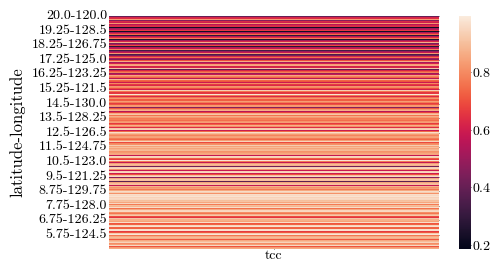

In [69]:
sns.heatmap(
    data=test
)

In [37]:
del save_df

In [ ]:
dataset = (
    DATA_PATH
    / "1940-02-f3f07b25d2a347b4745396922741d55b"
    / "total_cloud_cover_0_daily-mean.nc"
)

ds = xarray.open_dataset(dataset)

In [ ]:
save_data = ds.to_dataframe().reset_index()
save_data

,valid_time,latitude,longitude,tcc,number
0,1940-02-01,20.0,120.00,0.436661,0
1,1940-02-01,20.0,120.25,0.469696,0
2,1940-02-01,20.0,120.50,0.470810,0
3,1940-02-01,20.0,120.75,0.467484,0
4,1940-02-01,20.0,121.00,0.468040,0
...,...,...,...,...,...
72524,1940-02-29,5.0,129.00,0.725624,0
72525,1940-02-29,5.0,129.25,0.685135,0
72526,1940-02-29,5.0,129.50,0.620697,0
72527,1940-02-29,5.0,129.75,0.546349,0


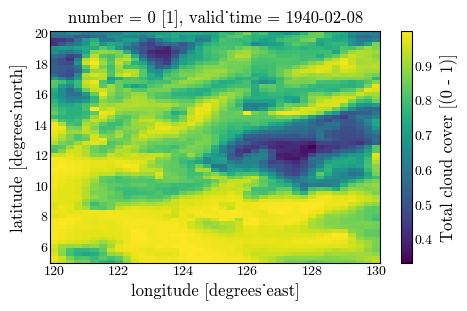

In [ ]:
# Select the total cloud cover variable
total_cloud_cover = ds["tcc"]

# Filter to a specific day (e.g., '2025-03-01')
specific_day = "1940-02-08"
total_cloud_cover_day = total_cloud_cover.sel(valid_time=specific_day)

# Plot the total cloud cover for the specific day as a 2D map
# plt.figure(figsize=(10, 6))
total_cloud_cover_day.plot(cmap="viridis")
# plt.title(f'Total Cloud Cover on {specific_day}')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
plt.show()